In [1]:
from models.cnep import CNEP
from models.cnep_abl0 import CNEP_ABL0
from models.cnep_abl1 import CNEP_ABL1

from data.data_generators import *
import torch


torch.set_float32_matmul_precision('high')

def get_free_gpu():
    gpu_util = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)  # Switch GPU
        gpu_util.append((i, torch.cuda.utilization()))
    gpu_util.sort(key=lambda x: x[1])
    return gpu_util[0][0]

if torch.cuda.is_available():
    available_gpu = get_free_gpu()
    if available_gpu == 0:
        device = torch.device("cuda:0")
    else:
        device = torch.device(f"cuda:{available_gpu}")
else:
    device = torch.device("cpu")

print("Device :", device)

Device : cuda:0


In [2]:
batch_size = 32
n_max, m_max = 10, 10  # max number of points in context set and target set

t_steps = 200
num_demos = 128
num_classes = 4
num_indiv = num_demos//num_classes  # number of demos per class
noise_clip = 0.0
dx, dy = 1, 1

num_val = 32
num_val_indiv = num_val//num_classes

In [11]:
num_demos, v_num_demos = 128, 32
x = torch.linspace(0, 1, 200).repeat(num_demos, 1).unsqueeze(-1)
vx = torch.linspace(0, 1, 200).repeat(v_num_demos, 1).unsqueeze(-1)
y = torch.zeros((num_demos, x.shape[1], 1))
vy = torch.zeros((v_num_demos, vx.shape[1], 1))

frequencies = [1, 2.5, 4, 5.5]  # Example frequencies
amplitudes = [1.5, 1, 0.8, 0.6]  # Example amplitudes
phases = [0, torch.pi / 2, torch.pi, 3 * torch.pi / 2]  # Example phases


for i in range(num_demos):
    y[i, :, 0] = amplitudes[i%2] * torch.sin(2 * torch.pi * frequencies[i%2] * x[i, :, 0] + phases[i%2]) + torch.randn(1) * 0.15
for i in range(v_num_demos):
    vy[i, :, 0] = amplitudes[i%2] * torch.sin(2 * torch.pi * frequencies[i%2] * vx[i, :, 0] + phases[i%2]) + torch.randn(1) * 0.15

print("X:", x.shape, "Y:", y.shape, "VX:", vx.shape, "VY:", vy.shape)
x, y, vx, vy = x.to(device), y.to(device), vx.to(device), vy.to(device)

X: torch.Size([128, 200, 1]) Y: torch.Size([128, 200, 1]) VX: torch.Size([32, 200, 1]) VY: torch.Size([32, 200, 1])


Text(0.5, 1.0, 'Sine Waves')

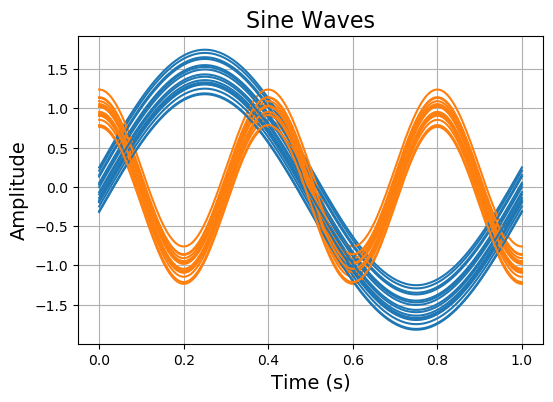

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

colors = [sns.color_palette('tab10')[0], sns.color_palette('tab10')[1], sns.color_palette('tab10')[2], sns.color_palette('tab10')[3]]
sns.set_palette('tab10')

plt.figure(figsize=(6, 4))
for i in range(num_val):
    if vy[i, 0, 0] < 0.5:
        group = 0
    else:
        group = 1
    plt.plot(vx[i, :, 0].cpu(), vy[i, :, 0].cpu(), color=colors[group])
    # plt.plot(vx[i, :, 0].cpu(), vy[i, :, 0].cpu(), 'k', alpha=0.5)

# plt.legend(loc='lower left', fontsize=14)
plt.grid(True)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.title(f'Sine Waves', fontsize=16)

In [4]:
obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
tar_x = torch.zeros((batch_size, m_max, dx), dtype=torch.float32, device=device)
tar_y = torch.zeros((batch_size, m_max, dy), dtype=torch.float32, device=device)
obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)
tar_mask = torch.zeros((batch_size, m_max), dtype=torch.bool, device=device)

def prepare_masked_batch(t: list, traj_ids: list):
    obs.fill_(0)
    tar_x.fill_(0)
    tar_y.fill_(0)
    obs_mask.fill_(False)
    tar_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = torch.randint(1, n_max, (1,)).item()
        m = torch.randint(1, m_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = permuted_ids[n:n+m]
        
        obs[i, :n, :dx] = traj[n_ids]
        obs[i, :n, dx:] = (n_ids/t_steps).unsqueeze(1)
        obs_mask[i, :n] = True
        
        tar_x[i, :m] = traj[m_ids]
        tar_y[i, :m] = (m_ids/t_steps).unsqueeze(1)
        tar_mask[i, :m] = True

val_obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dx), dtype=torch.float32, device=device)
val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

def prepare_masked_val_batch(t: list, traj_ids: list):
    val_obs.fill_(0)
    val_tar_x.fill_(0)
    val_tar_y.fill_(0)
    val_obs_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = torch.randint(1, n_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = torch.arange(t_steps)
        
        val_obs[i, :n, :dx] = traj[n_ids]
        val_obs[i, :n, dx:] = (n_ids/t_steps).unsqueeze(1)
        val_obs_mask[i, :n] = True
        
        val_tar_x[i] = traj[m_ids]
        val_tar_y[i] = (m_ids/t_steps).unsqueeze(1)

In [5]:
model_ = CNEP(1, 1, n_max, m_max, [128,128], num_decoders=2, decoder_hidden_dims=[128, 128], batch_size=batch_size, scale_coefs=True, device=device)
optimizer = torch.optim.Adam(lr=1e-4, params=model_.parameters())

model0_ = CNEP_ABL0(1, 1, n_max, m_max, [128,128], num_decoders=2, decoder_hidden_dims=[128, 128], batch_size=batch_size, scale_coefs=True, device=device)
optimizer0 = torch.optim.Adam(lr=1e-4, params=model0_.parameters())

model1_ = CNEP_ABL1(1, 1, n_max, m_max, [128,128], num_decoders=2, decoder_hidden_dims=[128, 128], batch_size=batch_size, scale_coefs=True, device=device)
optimizer1 = torch.optim.Adam(lr=1e-4, params=model1_.parameters())


if torch.__version__ >= "2.0":
    model, model0, model1 = torch.compile(model_), torch.compile(model0_), torch.compile(model1_)
else:
    model, model0, model1 = model_, model0_, model1_

In [6]:
import time
import os

timestamp = int(time.time())
root_folder = f'outputs/ablation/sines_2/orig_0_1/{str(timestamp)}/'

if not os.path.exists(root_folder):
    os.makedirs(root_folder)

if not os.path.exists(f'{root_folder}saved_models/'):
    os.makedirs(f'{root_folder}saved_models/')

if not os.path.exists(f'{root_folder}img/'):
    os.makedirs(f'{root_folder}img/')

torch.save(y, f'{root_folder}y.pt')


epochs = 1_000_000
epoch_iter = num_demos//batch_size  # number of batches per epoch (e.g. 100//32 = 3)
v_epoch_iter = num_val//batch_size  # number of batches per validation (e.g. 100//32 = 3)
avg_loss, avg_loss0, avg_loss1 = 0, 0, 0

val_per_epoch = 1000
min_vl, min_vl0, min_vl1 = 1000000, 1000000, 1000000

mse_loss = torch.nn.MSELoss()

tl, tl0, tl1 = [], [], []
ve, ve0, ve1 = [], [], []

cnep_tl_path = f'{root_folder}cnep_training_loss.pt'
cnep_ve_path = f'{root_folder}cnep_validation_error.pt'

for epoch in range(epochs):
    epoch_loss, epoch_loss0, epoch_loss1 = 0, 0, 0

    traj_ids = torch.randperm(x.shape[0])[:batch_size*epoch_iter].chunk(epoch_iter)  # [:batch_size*epoch_iter] because nof_trajectories may be indivisible by batch_size

    for i in range(epoch_iter):
        prepare_masked_batch(x, traj_ids[i])

        optimizer.zero_grad()
        pred, gate = model(obs, tar_x, obs_mask)
        loss, nll = model.loss(pred, gate, tar_y, tar_mask)
        loss.backward()
        optimizer.step()


        optimizer0.zero_grad()
        pred0, gate0 = model0(obs, tar_x, obs_mask)
        loss0, nll0 = model0.loss(pred0, gate0, tar_y, tar_mask)
        loss0.backward()
        optimizer0.step()


        optimizer1.zero_grad()
        pred1, gate1 = model1(obs, tar_x, obs_mask)
        loss1, nll1 = model1.loss(pred1, gate1, tar_y, tar_mask)
        loss1.backward()
        optimizer1.step()

        epoch_loss += nll.item()
        epoch_loss0 += nll0.item()
        epoch_loss1 += nll1.item()

    epoch_loss = epoch_loss/num_demos
    epoch_loss0 = epoch_loss0/num_demos
    epoch_loss1 = epoch_loss1/num_demos

    tl.append(epoch_loss)
    tl0.append(epoch_loss0)
    tl1.append(epoch_loss1)

    if epoch % val_per_epoch == 0:
        with torch.no_grad():
            v_traj_ids = torch.randperm(vx.shape[0])[:batch_size*v_epoch_iter].chunk(v_epoch_iter)
            val_loss, val_loss0, val_loss1 = 0, 0, 0

            for j in range(v_epoch_iter):
                prepare_masked_val_batch(vx, v_traj_ids[j])

                p_wta, g_wta = model.val(val_obs, val_tar_x, val_obs_mask)
                dec_id = torch.argmax(g_wta.squeeze(1), dim=-1)
                vp_means = p_wta[dec_id, torch.arange(batch_size), :, :dy]
                val_loss += mse_loss(vp_means, val_tar_y).item()

                p_wta, g_wta = model0.val(val_obs, val_tar_x, val_obs_mask)
                dec_id = torch.argmax(g_wta.squeeze(1), dim=-1)
                vp_means = p_wta[dec_id, torch.arange(batch_size), :, :dy]
                val_loss0 += mse_loss(vp_means, val_tar_y).item()

                p_wta, g_wta = model1.val(val_obs, val_tar_x, val_obs_mask)
                dec_id = torch.argmax(g_wta.squeeze(1), dim=-1)
                vp_means = p_wta[dec_id, torch.arange(batch_size), :, :dy]
                val_loss1 += mse_loss(vp_means, val_tar_y).item()


            val_loss /= num_val
            val_loss0 /= num_val
            val_loss1 /= num_val

            ve.append(val_loss)
            ve0.append(val_loss0)
            ve1.append(val_loss1)

            if val_loss < min_vl:
                min_vl = val_loss
                print(f'New best Orig: {min_vl}')
                torch.save(model_.state_dict(), f'{root_folder}saved_models/org.pt')

            if val_loss0 < min_vl0:
                min_vl0 = val_loss0
                print(f'New best Abl 0: {min_vl0}')
                torch.save(model0_.state_dict(), f'{root_folder}saved_models/abl0.pt')

            if val_loss1 < min_vl1:
                min_vl1 = val_loss1
                print(f'New best Abl 1: {min_vl1}')
                torch.save(model1_.state_dict(), f'{root_folder}saved_models/abl1.pt')
            
            print(f'Bests: {min_vl}, {min_vl0}, {min_vl1}')

    avg_loss += epoch_loss
    avg_loss0 += epoch_loss0
    avg_loss1 += epoch_loss1

    if epoch % val_per_epoch == 0:
        print("Epoch: {}, Orig: {}, Abl0: {}, Abl1: {}".format(epoch, avg_loss/val_per_epoch, avg_loss0/val_per_epoch, avg_loss1/val_per_epoch))
        avg_loss, avg_loss0, avg_loss1 = 0, 0, 0

torch.save(torch.Tensor(tl), cnep_tl_path)
torch.save(torch.Tensor(ve), cnep_ve_path)
torch.save(torch.Tensor(tl0), cnep_tl_path+'_abl0')
torch.save(torch.Tensor(ve0), cnep_ve_path+'_abl0')
torch.save(torch.Tensor(tl1), cnep_tl_path+'_abl1')
torch.save(torch.Tensor(ve1), cnep_ve_path+'_abl1')

New best Orig: 0.008344843983650208
New best Abl 0: 0.011144616641104221
New best Abl 1: 0.010449687950313091
Bests: 0.008344843983650208, 0.011144616641104221, 0.010449687950313091
Epoch: 0, Orig: 2.781808841973543e-05, Abl0: 3.089065663516521e-05, Abl1: 3.066613571718335e-05
New best Orig: 9.168044101670603e-09
New best Abl 0: 6.026697363381572e-09
New best Abl 1: 1.164639229500608e-08
Bests: 9.168044101670603e-09, 6.026697363381572e-09, 1.164639229500608e-08
Epoch: 1000, Orig: -0.10710034278343665, Abl0: -0.09245694484026899, Abl1: -0.10275728720507323
New best Orig: 4.6521941854393845e-09
New best Abl 1: 1.605367505597144e-09
Bests: 4.6521941854393845e-09, 6.026697363381572e-09, 1.605367505597144e-09
Epoch: 2000, Orig: -0.13901684467261657, Abl0: -0.1345805387031287, Abl1: -0.14692776337983376
New best Abl 0: 1.0944390949063632e-09
Bests: 4.6521941854393845e-09, 1.0944390949063632e-09, 1.605367505597144e-09
Epoch: 3000, Orig: -0.14189068588614465, Abl0: -0.14057171723185458, Abl1: 